In [10]:
import os
current_dir = %pwd
project_dir = os.path.dirname(current_dir)
%cd $project_dir

c:\Users\Bryan Fernandez\Desktop\doc-classifier


C:\Users\Bryan Fernandez\AppData\Roaming\Python\Python310\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from src import save_jsonfile, read_jsonfile, create_train_dataset, plot_history
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Activation, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
learning_rate = 0.0001
batch_size = 32

# Vérification de la GPU

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Chargement de la base de données

In [4]:
# Lire le fichier CSV
df_train = pd.read_csv('data/processed/DL_train.csv')
df_test = pd.read_csv('data/processed/DL_test.csv')

# Convertir les chemins d'images et les étiquettes en tenseurs
X_train = df_train['image_path'].values
Y_train = df_train['category'].values
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=seed)

X_test = df_test['image_path'].values
y_test = df_test['category'].values

# Création du dataset train et val

In [5]:
train_dataset = create_train_dataset(X_train, y_train, batch_size)
val_dataset = create_train_dataset(X_val, y_val, batch_size)

# Création du modèle

In [6]:
def fire_module(x, squeeze_filters, expand_filters):
    squeezed = Conv2D(squeeze_filters, (1, 1), activation='relu')(x)
    expanded_1x1 = Conv2D(expand_filters, (1, 1), activation='relu')(squeezed)
    expanded_3x3 = Conv2D(expand_filters, (3, 3),
                          padding='same', activation='relu')(squeezed)
    return concatenate([expanded_1x1, expanded_3x3], axis=-1)


def SqueezeNet(input_shape=(224, 224, 3), num_classes=1000):
    input_img = Input(shape=input_shape)

    x = Conv2D(96, (7, 7), strides=(2, 2), padding='same',
               activation='relu')(input_img)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = Dropout(0.5)(x)

    x = Conv2D(num_classes, (1, 1), padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax')(x)

    model = Model(inputs=input_img, outputs=output, name='squeezenet')
    return model


model = SqueezeNet(input_shape=(224, 224, 3), num_classes=6)

# Compilation

In [7]:
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "squeezenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 96  14208       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 96)   0           ['conv2d[0][0]']                 
                                                                                         

# Callbacks

In [8]:
ckpt_best_acc = ModelCheckpoint(
    filepath='models/SqueezeNet_ckpt_best_acc.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1)

ckpt_best_loss = ModelCheckpoint(
    filepath='models/SqueezeNet_ckpt_best_loss.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-9,
    verbose=1)

# L'entrainement

In [9]:
# Entraîner le modèle

hist = model.fit(train_dataset,
                 epochs=100,
                 validation_data=val_dataset,
                 callbacks=[reduce_lr, ckpt_best_acc, ckpt_best_loss])

Epoch 1/100
171/171 [==============================] - ETA: 0s - loss: 1.7051 - accuracy: 0.2230
Epoch 1: val_accuracy improved from -inf to 0.37023, saving model to models\SqueezeNet_ckpt_best_acc.keras

Epoch 1: val_loss improved from inf to 1.32894, saving model to models\SqueezeNet_ckpt_best_loss.keras
171/171 [==============================] - 142s 792ms/step - loss: 1.7051 - accuracy: 0.2230 - val_loss: 1.3289 - val_accuracy: 0.3702 - lr: 1.0000e-04
Epoch 2/100
171/171 [==============================] - ETA: 0s - loss: 1.0933 - accuracy: 0.4408
Epoch 2: val_accuracy improved from 0.37023 to 0.45821, saving model to models\SqueezeNet_ckpt_best_acc.keras

Epoch 2: val_loss improved from 1.32894 to 1.01935, saving model to models\SqueezeNet_ckpt_best_loss.keras
171/171 [==============================] - 139s 813ms/step - loss: 1.0933 - accuracy: 0.4408 - val_loss: 1.0193 - val_accuracy: 0.4582 - lr: 1.0000e-04
Epoch 3/100
171/171 [==============================] - ETA: 0s - loss: 0.

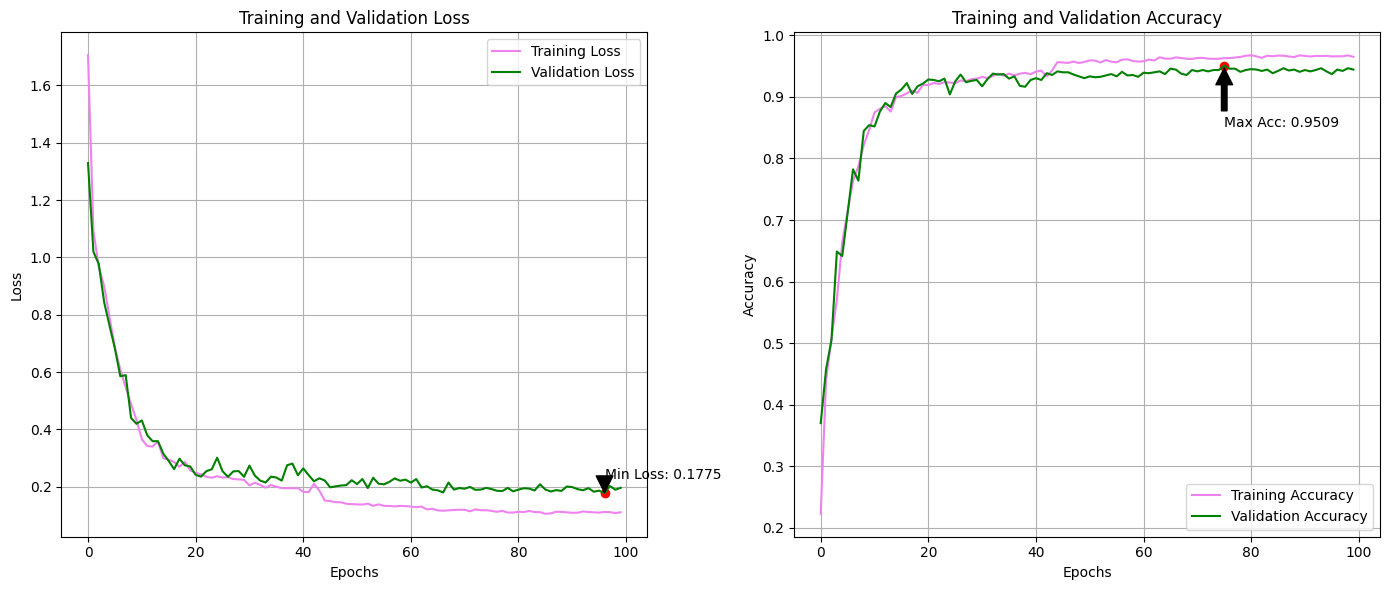

In [12]:
import matplotlib.pyplot as plt
import json

# Lire l'historique de l'entraînement à partir du fichier JSON


def read_jsonfile(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return data


# Charger l'historique
history = read_jsonfile('models/SqueezeNet_history.json')

# Tracer les courbes de loss et d'accuracy pour l'entraînement et la validation


def plot_history(history):
    # Tracer la loss
    plt.figure(figsize=(14, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss', color='violet')
    plt.plot(history['val_loss'], label='Validation Loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Annoter le minimum de la loss de validation
    min_val_loss = min(history['val_loss'])
    min_val_loss_epoch = history['val_loss'].index(min_val_loss)
    plt.scatter(min_val_loss_epoch, min_val_loss, color='red')
    plt.annotate(f'Min Loss: {min_val_loss:.4f}', xy=(min_val_loss_epoch, min_val_loss),
                 xytext=(min_val_loss_epoch, min_val_loss + 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy', color='violet')
    plt.plot(history['val_accuracy'],
             label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Annoter le maximum de l'accuracy de validation
    max_val_acc = max(history['val_accuracy'])
    max_val_acc_epoch = history['val_accuracy'].index(max_val_acc)
    plt.scatter(max_val_acc_epoch, max_val_acc, color='red')
    plt.annotate(f'Max Acc: {max_val_acc:.4f}', xy=(max_val_acc_epoch, max_val_acc),
                 xytext=(max_val_acc_epoch, max_val_acc - 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()


# Afficher les courbes
plot_history(history)

# Sauvegarde history

In [14]:
hist.history['lr'] = np.array(hist.history['lr']).tolist()
save_jsonfile('models/SqueezeNet_history.json', hist.history, indent=4)

In [15]:
from joblib import load, dump

model_name = "SqueezNet.joblib"
dump(model, os.path.join('models', model_name))

INFO:tensorflow:Assets written to: ram://819166e3-17e6-4bc6-ae4c-50ba8066aaad/assets


INFO:tensorflow:Assets written to: ram://819166e3-17e6-4bc6-ae4c-50ba8066aaad/assets


['models\\SqueezNet.joblib']